In [1]:
import PollingSystem as PS
import MarkovianRP as MRP
import numpy as np

from matplotlib import pyplot as plt

In [2]:
beta = 1/16
ps = PS.PollingSystem(np.array([0.3, 0.01, 0.01])/beta, beta)

rp = MRP.RandomRP([1/3, 1/3, 1/3])
s12 = [0.001, 0.1, 0.5, 1, 2, 5, 10, 20]
d = 500
for s in s12:
    S =  np.array([[0, s, d],[s, 0, np.sqrt(d+s**2)],[1.5, np.sqrt(d+s**2), 0]])
    wait = ps.calc_avg_wait(rp, S)
    print("Theoretical Wait Time: %f"%(wait))

Theoretical Wait Time: 265.327131
Theoretical Wait Time: 265.281608
Theoretical Wait Time: 265.098331
Theoretical Wait Time: 264.870762
Theoretical Wait Time: 264.421056
Theoretical Wait Time: 263.122326
Theoretical Wait Time: 261.173551
Theoretical Wait Time: 258.383949


In [3]:
#NOTE: decreasing switching time does NOT guarantee decreasing average waiting time

In [12]:
beta = 1/16
els = np.array([0.3, 0.01, 0.01])/beta
ps = PS.PollingSystem(els, beta)
#P = np.array([[0, 0.2, 0.8],[0.4, 0, 0.6],[0.5, 0.5, 0]])
#rp = MRP.MarkovianRP(P)
pi = [1/3, 1/4, 5/12]
rp = MRP.RandomRP(pi)
S =  np.array([[0, 15, 1],[15, 0, np.sqrt(16)],[1,np.sqrt(16), 0]])/4
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
hrs = 10
mins = hrs*60
seconds = mins*60
xt, wt, queues,_ = ps.simulate(rp, S, seconds)
print('Empirical Wait Time: %.2f'%(wt[-1][1]))

Theoretical Wait Time: 3.2753
Empirical Wait Time: 3.50


In [5]:
int_queue_length = 0
for i in range(len(xt)-1):
    int_queue_length += (xt[i+1][0]-xt[i][0])*sum(xt[i][1:])
lbar = int_queue_length/xt[-2][0]
print(lbar)
#littles_law_wait
print(lbar/sum(els))

17.648933456420455
3.44705731570712
[3.  4.  2.4]


5.12

In [6]:
sum_of_all_wait_times = 0
n_serviced = 0
for q in queues:
    sum_of_all_wait_times += sum(q.wait_times)
    n_serviced += len(q.wait_times)
    
#better calculation here?
sum_of_all_wait_times/n_serviced

3.486865535212226

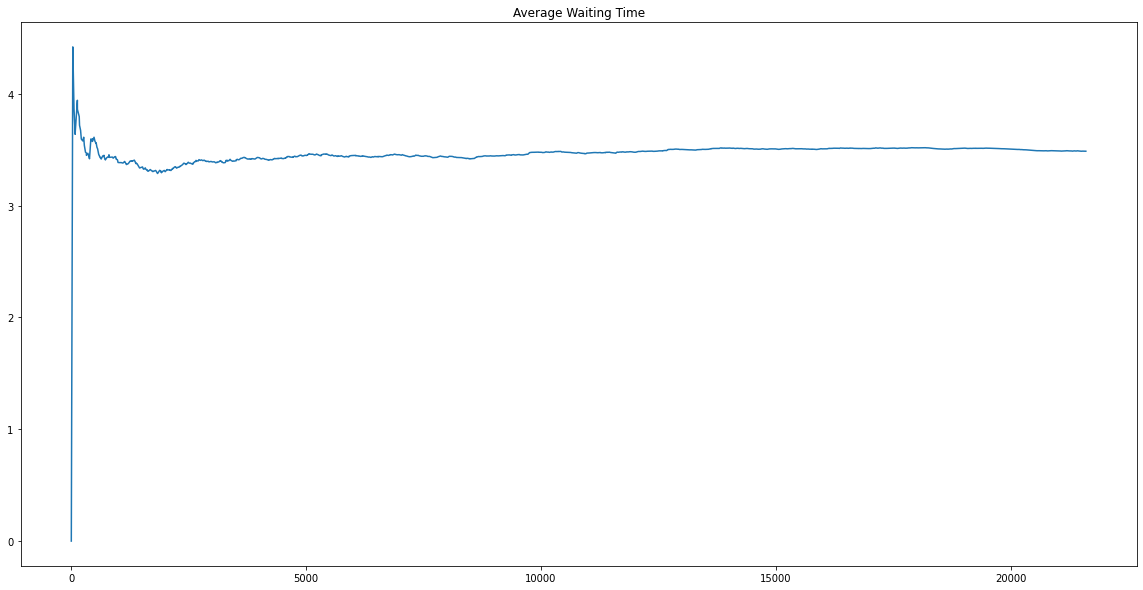

In [8]:
wt = np.array(wt)
fig = plt.figure(figsize=[20,10])
plt.plot(wt[:,0], wt[0:,1])
plt.title("Average Waiting Time")
plt.show()

In [47]:
def tail_avg_wait(queues, tail_start, Ls):
    avg = 0
    for i in range(len(queues)):
        queue = queues[i]
        sst = queue.service_start_times
        upper_i = len(sst) - 1
        lower_i = 0
        while upper_i - lower_i != 1:
            test_i = (upper_i + lower_i)//2
            if sst[test_i] < tail_start:
                lower_i = test_i
            elif sst[test_i] > tail_start:
                upper_i = test_i
            else:
                upper_i = test_i
                lower_i = test_i-1
        q_tail = queue.wait_times[upper_i:]
        avg += Ls[i]*np.mean(q_tail)
    return avg/np.sum(Ls)

tail_avg_wait(queues, 1000, els)

3.465431053486929

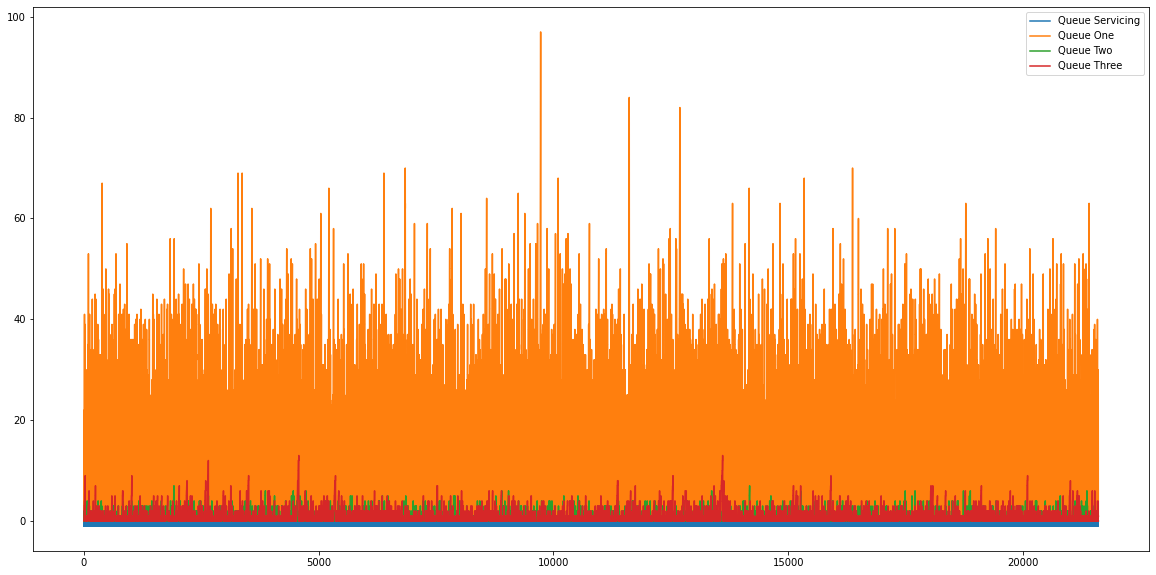

In [11]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0], xt[:,2], label = 'Queue One')
plt.plot(xt[:,0], xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0], xt[:,4], label = 'Queue Three')
plt.legend()
#plt.xlim(19000,20000)
plt.show()

In [49]:
res = ps.calc_optiaml_rp(S)
print(res)

     fun: 4.906031021147757
     jac: array([3.89966959, 3.89420819, 3.89767259])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.07410498, 0.0310437 , 0.89485132])


4.906647130845505


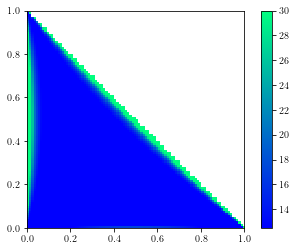

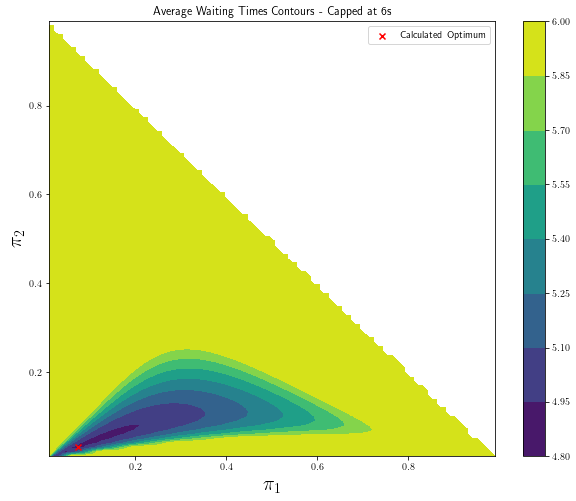

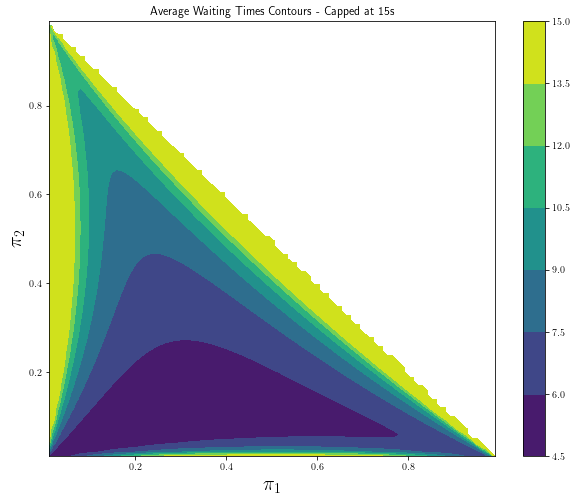

In [50]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

gran = 100
pi1 = np.linspace(1/gran,1-(1/gran), gran)
pi2 = np.linspace(1/gran,1 - (1/gran), gran)
Z = -1*np.Inf*np.ones([gran, gran])

fmin = 10000
for i in range(gran):
    for j in range(gran):
        pi = np.array([pi1[i], pi2[j], 1 - pi1[i] - pi2[j]])
        if pi[2] > 0:
            Z[i,j] = ps._calc_avg_wait_random( pi , S)
            if Z[i,j] < fmin:
                fmin=Z[i,j]
print(fmin)

fig, ax = plt.subplots()
ws = ax.imshow(np.transpose(Z), extent=[0,1,0,1], cmap='winter', interpolation='nearest',
               vmin=12.5,vmax=30, origin='lower')
fig.colorbar(ws)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 6))
#cont = plt.contourf(pi1, pi2, np.minimum(np.log(Z.T), 2.6) )
fig.colorbar(cont)
plt.scatter(res.x[0], res.x[1], label='Calculated Optimum', marker='x', c='r')
plt.legend()
plt.title('Average Waiting Times Contours - Capped at 6s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 15))
fig.colorbar(cont)
plt.title('Average Waiting Times Contours - Capped at 15s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

In [10]:
#Contours are clearly non-convex. We're not dealing with a convex function.
#There doesn't seem to be a good way to verify unimodality, either

In [6]:
wt

[[0.0, 0.0],
 [1.0, 0.0],
 [11.449489742783172, 4.810577276457236],
 [25.449489742783197, 5.996869125095654],
 [33.44948974278322, 6.458916438928569],
 [40.44948974278325, 6.480595434554741],
 [50.89897948556646, 6.495536639019141],
 [55.898979485566485, 6.295950639937349],
 [55.898979485566485, 6.295950639937349],
 [58.348469228349664, 6.295950639937349],
 [65.79795897113286, 5.997687341029218],
 [77.24744871391592, 5.830234607921931],
 [79.69693845669909, 5.830234607921931],
 [86.14642819948214, 5.649665045990662],
 [88.59591794226532, 5.649665045990662],
 [94.04540768504837, 5.49338414176035],
 [109.49489742783143, 5.4298376091362535],
 [117.49489742783132, 5.522395360703529],
 [125.4948974278312, 5.541757494263057],
 [133.4948974278311, 5.496274189275127],
 [145.29285639896372, 5.410620023156765],
 [153.2928563989636, 5.459660619274925],
 [158.2928563989636, 5.459660619274925],
 [161.2928563989635, 5.503703183759251],
 [174.29285639896338, 5.541463198900879],
 [177.29285639896327, 